In [1]:
from __future__ import annotations

from pathlib import Path

import geopandas as gpd

from slope_area.enums import Column, SlopeAreaMethod
from slope_area.features import Outlet, Outlets
from slope_area.geomorphometry import DefaultSlopeProviders
from slope_area.logger import create_logger
from slope_area.paths import PROJ_ROOT
from slope_area.plot import SlopeAreaPlotConfig
from slope_area.trial import (
    AnalysisConfig,
    HydrologicAnalysisConfig,
    OutletTrialFactory,
    ResolutionTrialFactory,
    Trial,
    TrialContext,
    TrialData,
    TrialFactoryContext,
    TrialResults,
    Trials,
)

logger = create_logger(__name__)

10:13:16 DEBUG slopeArea.slope_area.config          is_notebook(): Code is running in notebook


# Paths

In [2]:
dem = PROJ_ROOT / 'data' / 'raw' / 'copdem_30m.tif'
outlets = PROJ_ROOT / 'data' / 'raw' / 'copdem_30m_outlets.shp'

out_dir = PROJ_ROOT / 'data' / 'processed' / '01_plot_from_outlets'
out_dir_sequential = out_dir / 'sequential'
out_dir_parallel = out_dir / 'parallel'
out_dir_outlet = out_dir / 'outlet'
out_dir_resolution = out_dir / 'resolution'

out_fig_sequential = out_dir_sequential / 'slope_area.png'
out_fig_outlet = out_dir_outlet / 'slope_area.png'
out_fig_resolution = out_dir_resolution / 'slope_area.png'

assert dem.exists()
assert outlets.exists()

# Configs

In [3]:
max_workers = 3
resolutions = [(res, res) for res in range(30, 60, 5)]
hydrologic_analysis_config = HydrologicAnalysisConfig(
    streams_flow_accumulation_threshold=1000, outlet_snap_distance=100
)
analysis_config = AnalysisConfig(
    method=SlopeAreaMethod.STREAMS,
    hydrologic=hydrologic_analysis_config,
    slope_providers=DefaultSlopeProviders.get_default_providers(),
)

plot_config = SlopeAreaPlotConfig(
    hue=Column.SLOPE_TYPE,
    col=Column.TRIAL_NAME,
    row=None,
    log_interval=0.25,
    min_gradient=0.01,
    col_wrap=-1,  # -1 infers number of columns
    height=5,
    aspect=1,
    title=None,
    xlabel='Drainage area (m$^2$)',
    ylabel='Slope (m/m)',
    label_font_size=16,
    title_font_size=10,
    legend_font_size=10,
    tick_font_size=14,
    add_vlines=False,
    kind='line',
    show=False,
)


def trial_from_outlet(outlet: Outlet, out_dir: Path) -> Trial:
    assert outlet.name is not None
    name = f'Trial {outlet.name}'
    context = TrialContext(
        out_dir=out_dir / name,
        data=TrialData(outlet=outlet, dem=dem, resolution=None),
        analysis=analysis_config,
    )
    return Trial(name=name, context=context)

# Read outlets

In [4]:
logger.info('Reading outlets at %s' % outlets)
gdf = gpd.read_file(outlets).sort_values(by='name')
outlets = Outlets.from_gdf(gdf, name_field='name')

10:13:18 INFO slopeArea.__main__             <module>(): Reading outlets at /media/alex/alex/python-modules-packages-utils/slope-area/data/raw/copdem_30m_outlets.shp


# Run trials sequentially

In [5]:
trials = Trials(
    [trial_from_outlet(outlet, out_dir_sequential) for outlet in outlets]
)
results = TrialResults()
for trial in trials:
    results.append(trial.run())

10:13:18 INFO slopeArea.slope_area.trial.Trial                  run(): Running...
10:13:18 INFO slopeArea.slope_area.config          get_wbw_env(): Initialized Whitebox Environment
10:13:18 INFO slopeArea.slope_area.trial.Trial read_whitebox_raster(): Reading raster copdem_30m.tif
10:13:18 INFO slopeArea.slope_area.trial.Trial       preprocess_dem(): Breaching depressions in the DEM
10:13:18 INFO slopeArea.slope_area.trial.Trial       preprocess_dem(): Breaching single-cell pits
10:13:18 INFO slopeArea.slope_area.geomorphometry              wrapper(): preprocess_dem executed in 0.122831 seconds
10:13:18 INFO slopeArea.slope_area.trial.Trial         compute_flow(): Computing the D8 pointer
10:13:19 INFO slopeArea.slope_area.trial.Trial         compute_flow(): Computing the flow accumulation
10:13:19 INFO slopeArea.slope_area.geomorphometry              wrapper(): compute_flow executed in 0.143708 seconds
**********************************************************************************


Slope types: ['Slope 3x3' 'Stream Slope Continuous']
          area slope_type     slope resolution           trial
0  2228.816650  Slope 3x3  0.026188       None  Trial outlet 1
1  1485.877686  Slope 3x3  0.033741       None  Trial outlet 1
2  4457.633301  Slope 3x3  0.028048       None  Trial outlet 1
3  3714.694336  Slope 3x3  0.033569       None  Trial outlet 1
4  2971.755371  Slope 3x3  0.036000       None  Trial outlet 1
10:13:45 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue=<Column.SLOPE_TYPE: 'slope_type'>, col=<Column.TRIAL_NAME: 'trial'>, row=None, log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend_font_size=10, legend_title='', legend=True, show=False)
10:13:45 INFO slopeArea.slope_area.plot         get_col_wrap(): 

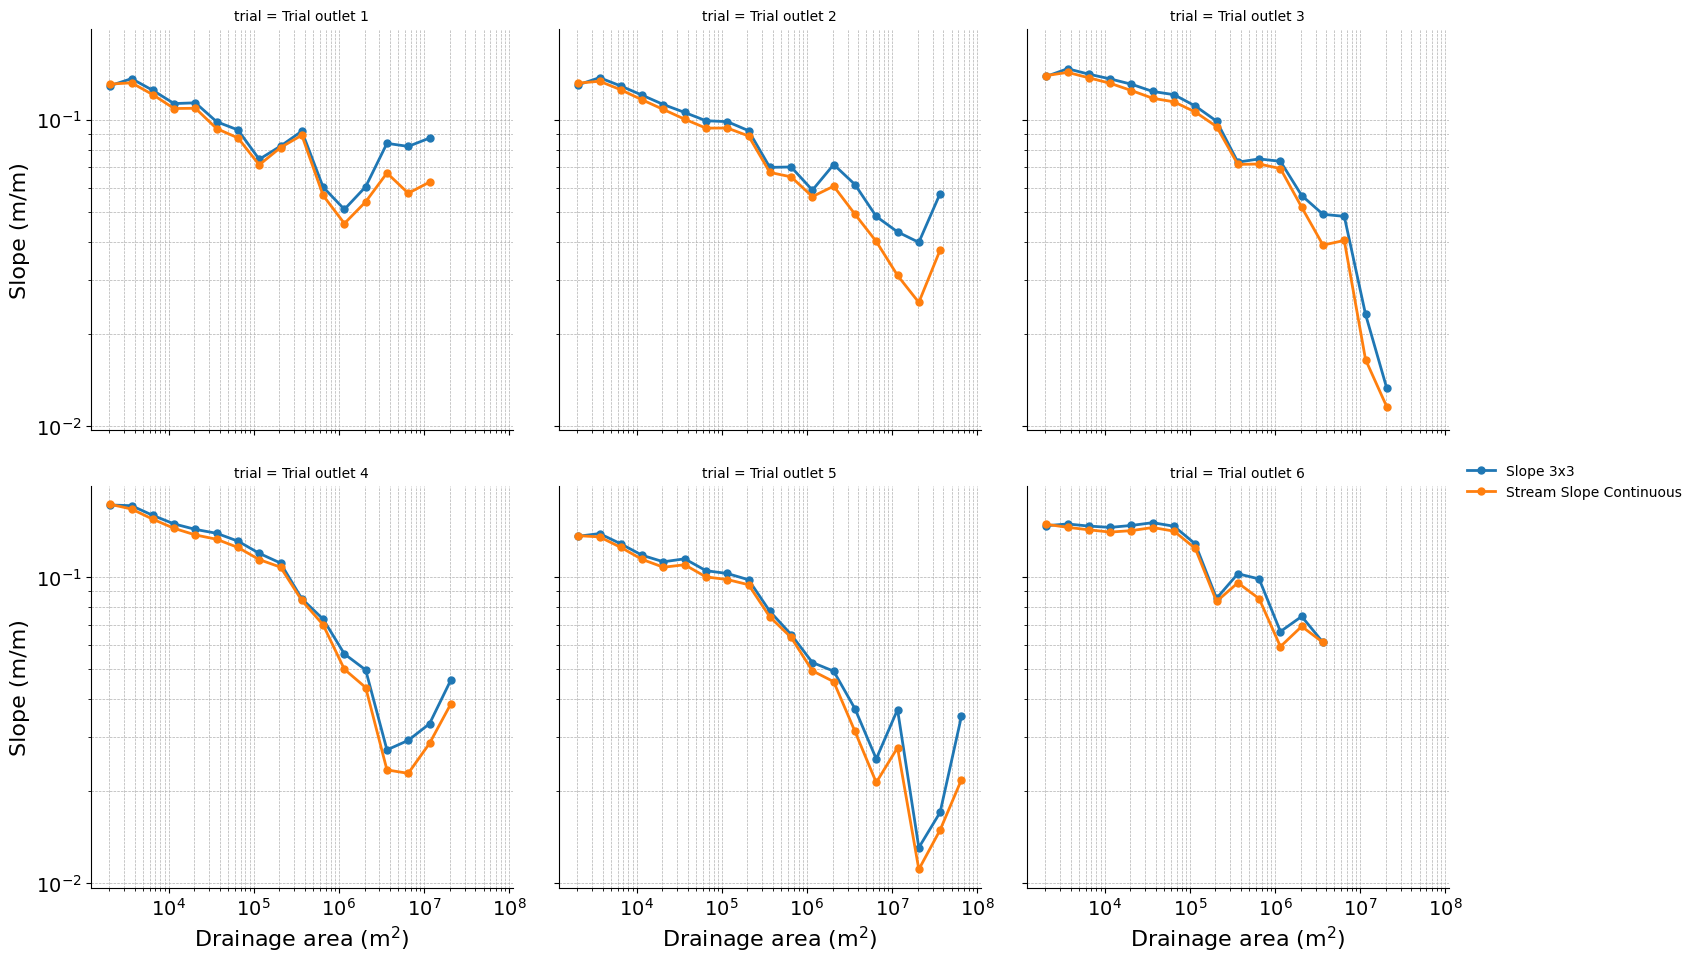

In [6]:
print('Slope types:', results[0].df[Column.SLOPE_TYPE].unique())
print(results[0].df.head())
results.plot(config=plot_config, out_fig=out_fig_sequential)

# Run trials in parallel

Output()

**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


10:14:19 INFO slopeArea.slope_area.trial.TrialsExecutor               gather(): Gathering results of TrialsExecutor
10:14:20 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue=<Column.SLOPE_TYPE: 'slope_type'>, col=<Column.TRIAL_NAME: 'trial'>, row=None, log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend_font_size=10, legend_title='', legend=True, show=False)
10:14:20 INFO slopeArea.slope_area.plot         get_col_wrap(): Infered 3 cols for the plot
10:14:24 INFO slopeArea.slope_area.plot      slope_area_grid(): Saved slope area plot at None


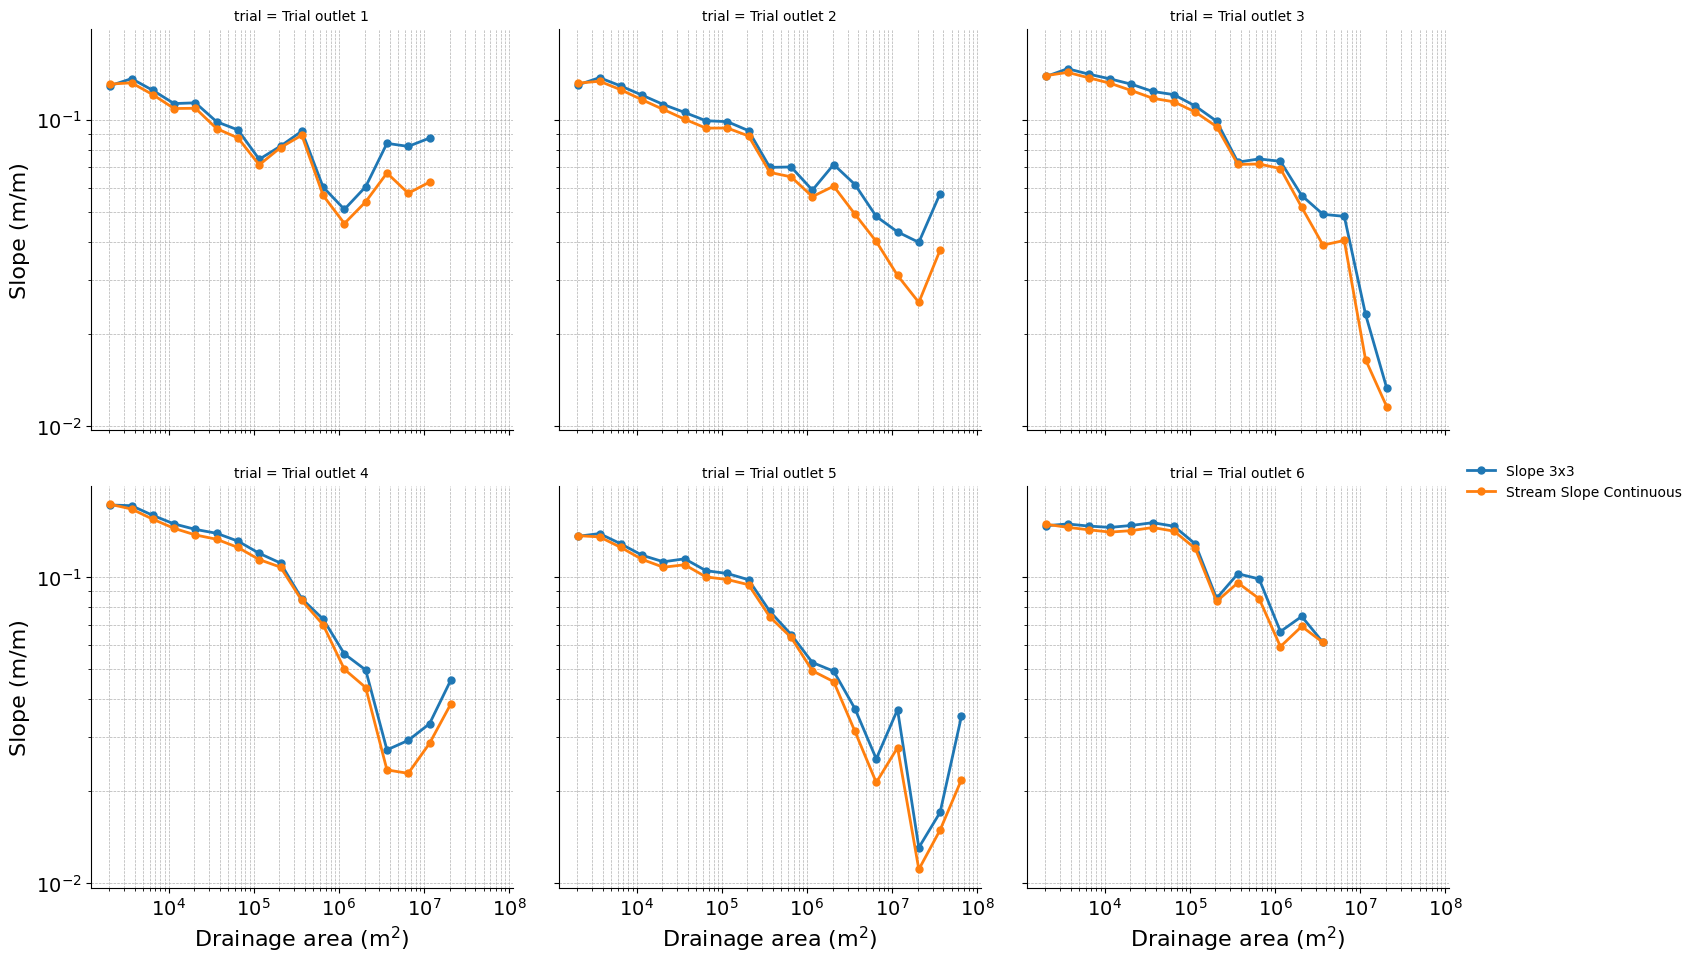

In [7]:
trials = Trials(
    [trial_from_outlet(outlet, out_dir_parallel) for outlet in outlets]
)
results = trials.run(max_workers=max_workers)
results.plot(config=plot_config)

# Trial factories

You can use TrialFactory objects for easier Trial creation

## Outlet factories

Output()

**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


10:14:49 INFO slopeArea.slope_area.trial.TrialsExecutor               gather(): Gathering results of TrialsExecutor
10:14:49 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue=<Column.SLOPE_TYPE: 'slope_type'>, col=<Column.TRIAL_NAME: 'trial'>, row=None, log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend_font_size=10, legend_title='', legend=True, show=False)
10:14:49 INFO slopeArea.slope_area.plot         get_col_wrap(): Infered 3 cols for the plot
10:14:56 INFO slopeArea.slope_area.plot      slope_area_grid(): Saved slope area plot at /media/alex/alex/python-modules-packages-utils/slope-area/data/processed/01_plot_from_outlets/outlet/slope_area.png


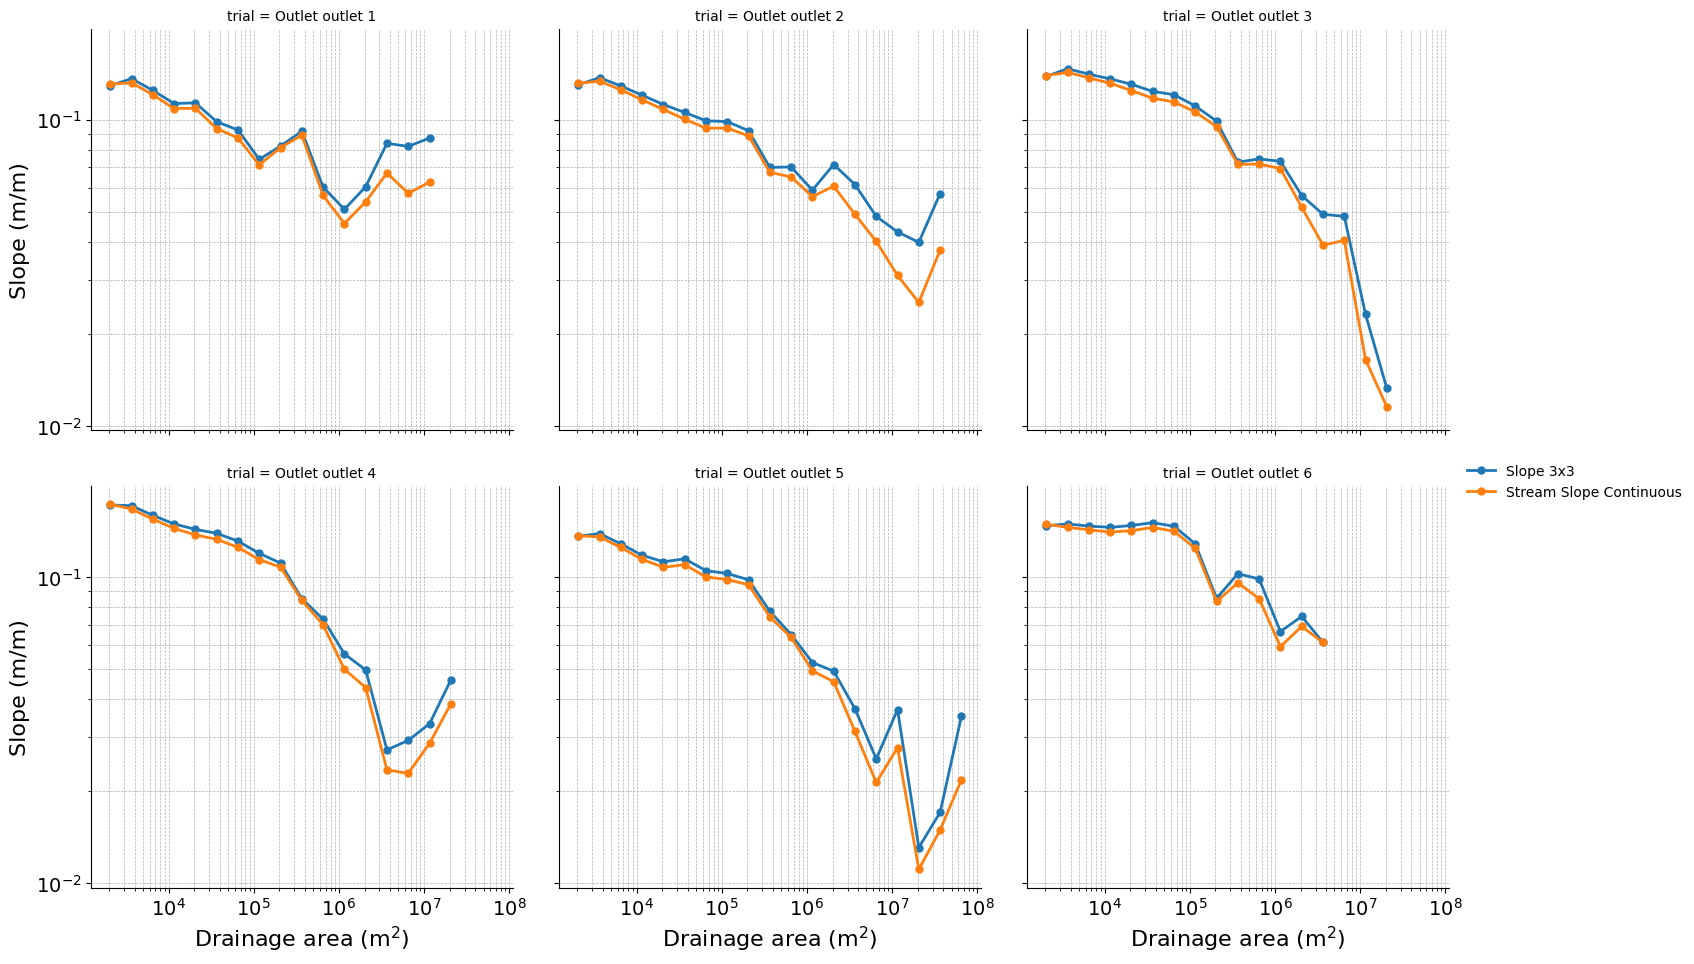

In [8]:
context = TrialFactoryContext(
    dem=dem, out_dir=out_dir_outlet, analysis=analysis_config
)
trials = OutletTrialFactory(
    context=context, outlets=outlets, resolution=None
).generate()
results = trials.run(max_workers)
grid = results.plot(config=plot_config, out_fig=out_fig_outlet)

## ResolutionPlotBuilder - multiple resolutions for one outlet

Output()

**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


10:15:11 INFO slopeArea.slope_area.trial.TrialsExecutor               gather(): Gathering results of TrialsExecutor
10:15:11 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue=<Column.SLOPE_TYPE: 'slope_type'>, col=<Column.TRIAL_NAME: 'trial'>, row=None, log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend_font_size=10, legend_title='', legend=True, show=False)
10:15:11 INFO slopeArea.slope_area.plot         get_col_wrap(): Infered 3 cols for the plot
10:15:17 INFO slopeArea.slope_area.plot      slope_area_grid(): Saved slope area plot at /media/alex/alex/python-modules-packages-utils/slope-area/data/processed/01_plot_from_outlets/resolution/slope_area.png


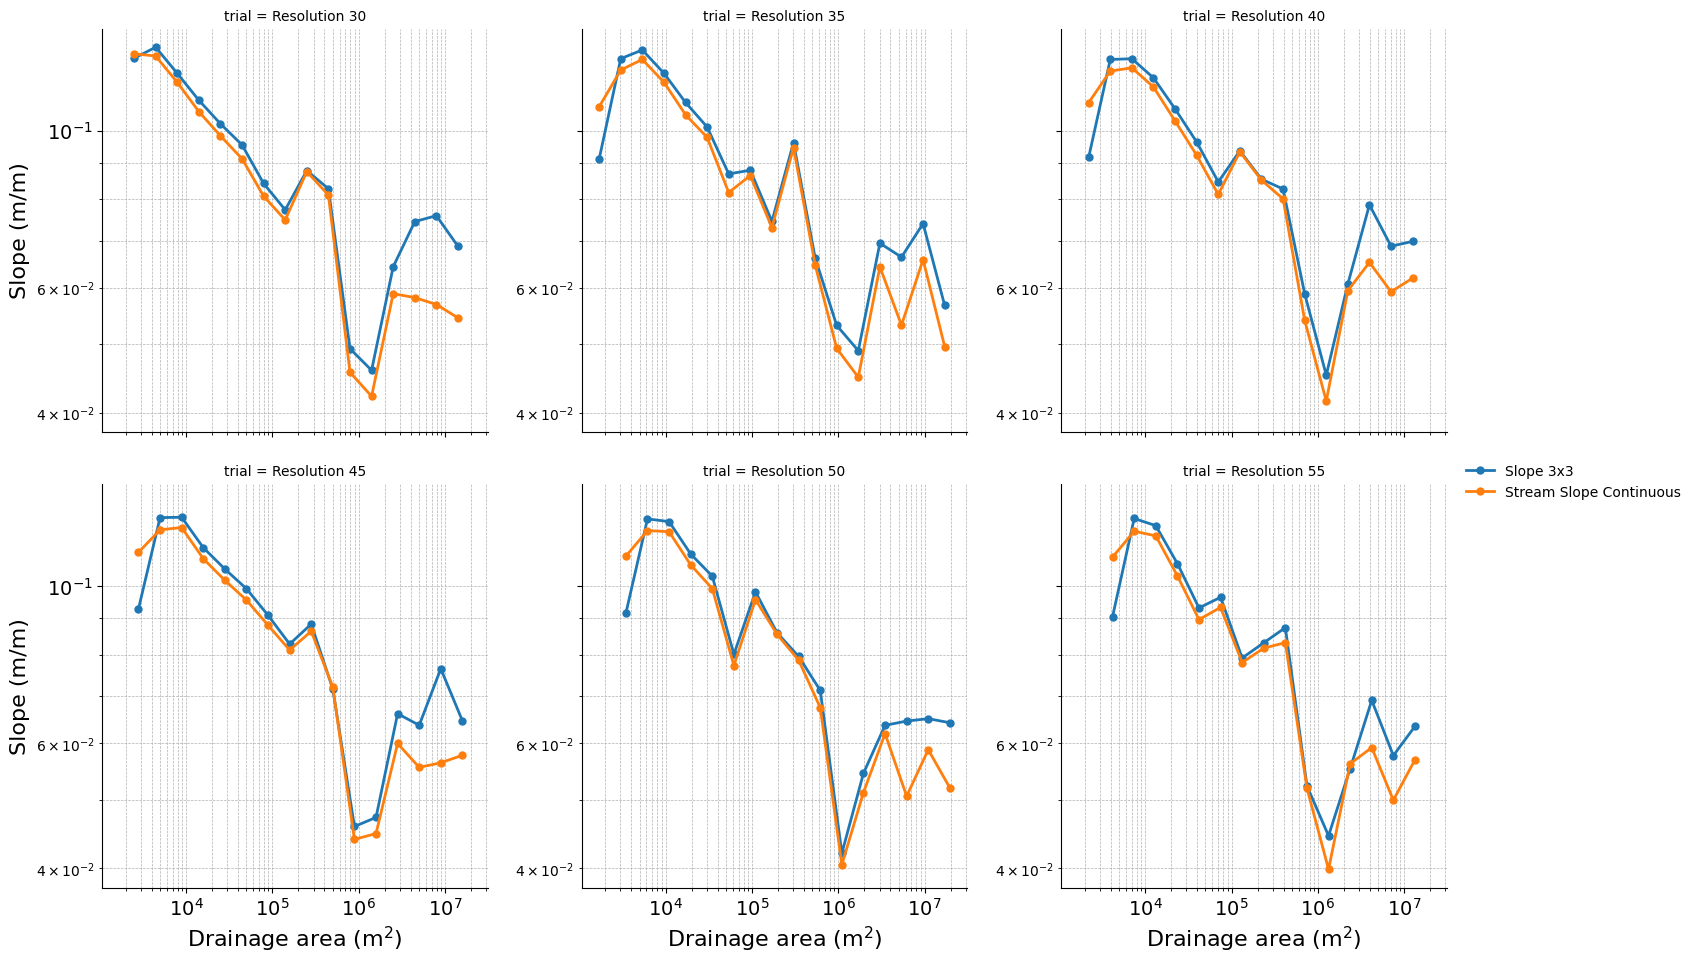

In [9]:
outlet = outlets[0]

context = TrialFactoryContext(
    dem=dem, out_dir=out_dir_resolution, analysis=analysis_config
)
trials = ResolutionTrialFactory(
    context=context, outlet=outlet, resolutions=resolutions
).generate()
results = trials.run(max_workers)
grid = results.plot(config=plot_config, out_fig=out_fig_resolution)